# Theta phase detection and theta power computation
In this tutorial, we demonstrate how to generate analytic signals from the LFP data, as well as how to compute theta phases and power, all of which depend on methods built into the LFPBand table. Let's import the LFPBand table:

In [1]:
import numpy as np
from spyglass.lfp.v1 import LFPBand
import matplotlib.pyplot as plt

Please enter DataJoint username:  xulu


[2023-05-24 19:29:32,670][INFO]: Connecting xulu@lmf-db.cin.ucsf.edu:3306
[2023-05-24 19:29:32,722][INFO]: Connected xulu@lmf-db.cin.ucsf.edu:3306
/home/lorenlab/anaconda3/envs/spyglass/lib/python3.9/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


#### 1. Acquire theta band analytic signal from the LFPBand data for electrodes we want to perform theta analyses with.

__In order to acquire theta band data from LFPBand, we need to define the correct keys.__

We can first take a look at the LFPBand table to understand what primary keys it contains:

In [2]:
LFPBand()

lfp_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,filtered_data_object_id the NWB object ID for loading this object from the file
18ea201c-f121-11ed-aa77-f8f21e671294,theta_5_11,1000,chimi20200213_.nwb,chimi20200213_.nwb_02_r1 noPrePostTrialTimes_LFP_none_artifact_removed_valid_times,1000,chimi20200213_M8CCMU7UYG.nwb,chimi20200213_.nwb_02_r1 noPrePostTrialTimes_LFP_none_artifact_removed_valid_times lfp band 1000Hz,35275bb9-0509-4cdd-ba35-ae3d93387169
784930ce-f091-11ed-9473-ac1f6b0f717e,LFP 0-400 Hz,1000,pippin20210518_.nwb,pippin20210518_.nwb_r1_r2_LFP_default_artifact_removed_valid_times,1000,pippin20210518_37BO9HWO2P.nwb,pippin20210518_.nwb_r1_r2_LFP_default_artifact_removed_valid_times lfp band 1000Hz,64cb1c14-7635-432b-9273-c2214a410358
784930ce-f091-11ed-9473-ac1f6b0f717e,Ripple 150-250 Hz,1000,pippin20210518_.nwb,pippin20210518_.nwb_r1_r2_LFP_default_artifact_removed_valid_times,1000,pippin20210518_VYWKS2LP8Y.nwb,pippin20210518_.nwb_r1_r2_LFP_default_artifact_removed_valid_times lfp band 1000Hz,1d3c878b-b2a6-496c-b856-f6a0af11a051
81cbe85a-f06c-11ed-a02d-04d9f580fe36,Theta 5-11 Hz,1000,j1620210710_.nwb,test interval,1000,j1620210710_VEG6PIEL2F.nwb,test interval lfp band 1000Hz,a7a36a2e-3fa9-41db-853e-30a66a9e04f5
976afb32-ed48-11ed-97e3-ac1f6b0f717e,LFP 0-400 Hz,1000,molly20220401_.nwb,molly20220401_.nwb_r2_r3_LFP_default_artifact_removed_valid_times,1000,molly20220401_CHSGHKWB19.nwb,molly20220401_.nwb_r2_r3_LFP_default_artifact_removed_valid_times lfp band 1000Hz,8298babd-e094-4f55-8706-c8ce43e8eb5c
ac232662-f0ef-11ed-aeb9-f8f21e671294,Theta 5-11 Hz,1000,tonks20211103_.nwb,test interval,100,tonks20211103_PYAC8MUKPS.nwb,test interval lfp band 100Hz,f6d30142-38a0-497b-8d90-bec13fa9f86b
feffa256-f848-11ed-a2a3-04d9f580fe36,Theta 5-11 Hz,1000,j1620210710_.nwb,test_interval_one_session,1000,j1620210710_MO2OQRLMV4.nwb,test_interval_one_session lfp band 1000Hz,902ba18a-7066-4202-b2fd-88d492d35401


Now create a dictionary of keys that index the theta band data we want to analyze.

In [3]:
nwb_file_name = "j1620210710_.nwb"
lfp_key = dict()
lfp_key["nwb_file_name"] = nwb_file_name
lfp_key["filter_name"] = "Theta 5-11 Hz"
# Use the same interval list name as in the LFPBand entry of interest; here for simplicity, we will use a test interval
lfp_key["target_interval_list_name"] = "test_interval_one_session"

(
    LFPBand() & lfp_key
)  # Make sure that this prints out the entry we want to analyze

lfp_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,filtered_data_object_id the NWB object ID for loading this object from the file
feffa256-f848-11ed-a2a3-04d9f580fe36,Theta 5-11 Hz,1000,j1620210710_.nwb,test_interval_one_session,1000,j1620210710_MO2OQRLMV4.nwb,test_interval_one_session lfp band 1000Hz,902ba18a-7066-4202-b2fd-88d492d35401


Because we do not need all electrodes for computing theta phase/power, we should define a list of electrodes for theta analyses. __Here, we choose the hippocampal reference electrode ids we used during recording because we usually use them to determine theta phase and power.__

In [7]:
electrode_list = [
    0,
    40,
]

Make sure that the electrodes defined in the eletrode_list already exist in the LFPBand data; if not, go to the LFP tutorial to generate them.

In [8]:
# Get all the eletrode ids in the LFPBand data:
all_electrodes = (
    (LFPBand() & lfp_key).fetch_nwb()[0]["filtered_data"]
).electrodes.data[:]
# Check if electrodes defined in our electrode_list exist in the LFPBand data:
np.isin(electrode_list, all_electrodes)

array([ True,  True])

In [9]:
# Compute the theta analytic signal.
theta_analytic_signal = (LFPBand() & lfp_key).compute_analytic_signal(
    electrode_list=electrode_list
)

theta_analytic_signal

,electrode 0,electrode 40
time,,
1.625936e+09,-8.00000+0113.958580j,-28.000000+127.578749j
1.625936e+09,-12.000000+84.275575j,-33.000000+94.369967j
1.625936e+09,-15.000000+86.760325j,-37.000000+96.216452j
1.625936e+09,-19.000000+78.099686j,-42.000000+85.408355j
1.625936e+09,-23.000000+79.717213j,-46.000000+85.895887j
...,...,...
1.625936e+09,49.000000+54.115342j,35.000000+64.803958j
1.625936e+09,48.000000+56.641484j,34.000000+67.018773j
1.625936e+09,48.000000+69.764801j,33.000000+81.095129j


In the theta_analytic_signal dataframe above, the index is the timestamps, and the columns are the analytic sinals of theta band (complex numbers) for electrodes that we defined in eletrode_list.

#### 2. Using a similar method, we can compute theta phase and power from the LFPBand table.

In [10]:
# Compute the theta phase and power for electrodes in the electrode_list we previously defined.
theta_phase = (LFPBand() & lfp_key).compute_signal_phase(
    electrode_list=electrode_list
)
theta_power = (LFPBand() & lfp_key).compute_signal_power(
    electrode_list=electrode_list
)

In [11]:
# Get theta band data that will be jointly plotted with the theta phase results.
theta_band = (LFPBand() & lfp_key).fetch_nwb()[0]["filtered_data"]
electrode_index = np.isin(theta_band.electrodes.data[:], electrode_list)
theta_band_selected = theta_band.data[:, electrode_index]

#### 3. Plot the results: overlay theta and detected phase for one example lfp electrode.
Note that the red horizontal line indicates phase 0 (corresponding to the trough of theta).

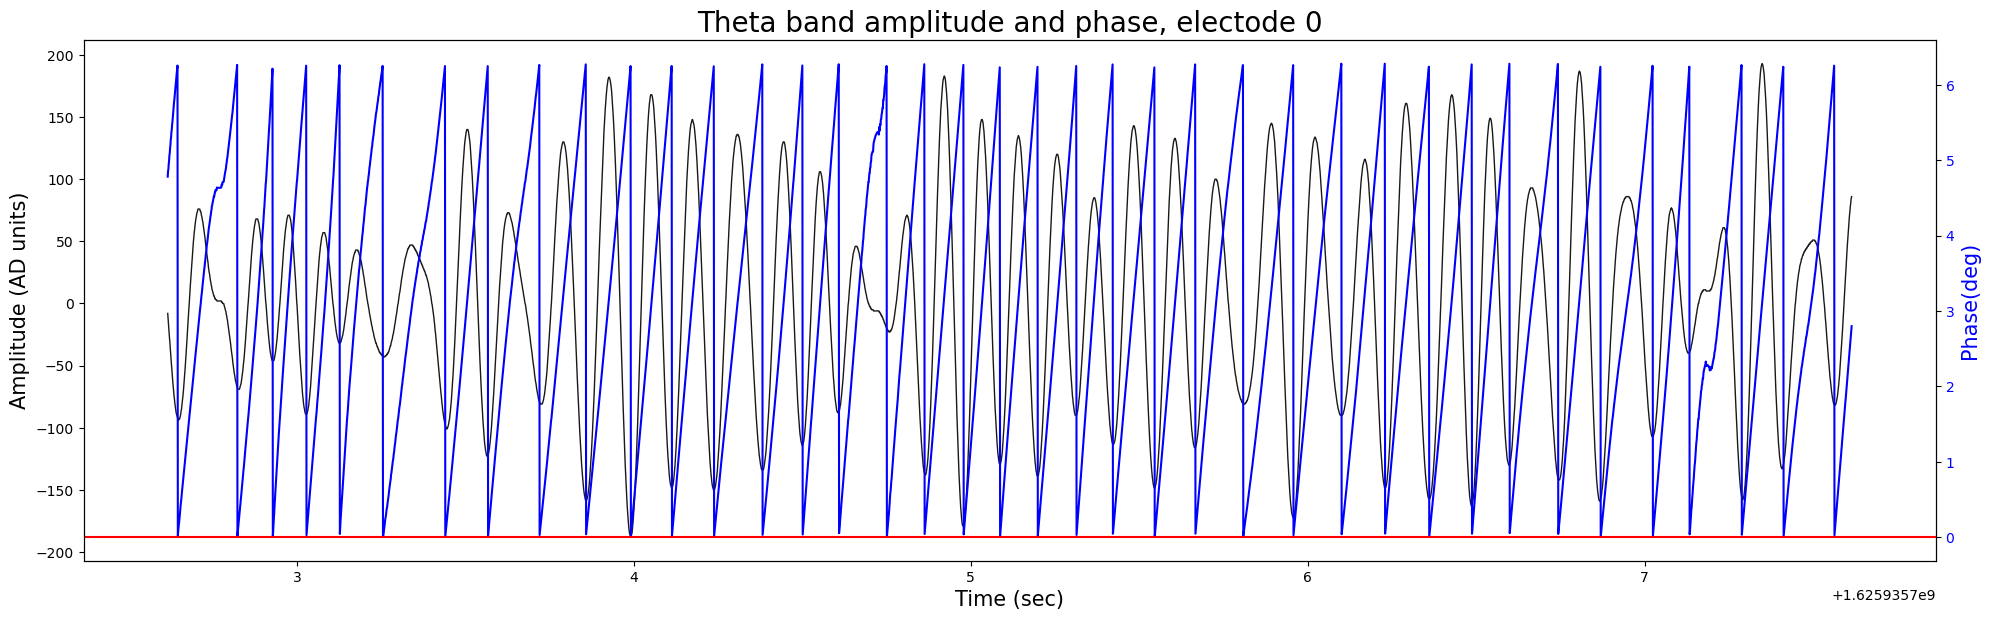

In [12]:
electrode_id = electrode_list[0]  # the electrode for which we want to plot
plot_start = 0  # the start time of plotting
plot_end = 5000  # the end time of plotting
fig, ax1 = plt.subplots(figsize=(20, 6))
ax1.set_xlabel("Time (sec)", fontsize=15)
ax1.set_ylabel("Amplitude (AD units)", fontsize=15)
ax1.plot(
    theta_phase.index[plot_start:plot_end],
    theta_band_selected[
        plot_start:plot_end, np.where(np.array(electrode_list) == 0)[0][0]
    ],
    "k-",
    linewidth=1,
    alpha=0.9,
)
ax1.tick_params(axis="y", labelcolor="k")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("Phase(deg)", color="b", fontsize=15)
ax2.plot(
    theta_phase.index[plot_start:plot_end],
    theta_phase[f"electrode {electrode_id}"].iloc[plot_start:plot_end],
    "b",
)
ax2.tick_params(axis="y", labelcolor="b")
ax2.axhline(y=0, color="r", linestyle="-")
fig.tight_layout()
ax1.set_title(
    f"Theta band amplitude and phase, electode {electrode_id}",
    fontsize=20,
);

We can also plot the theta power if interested.

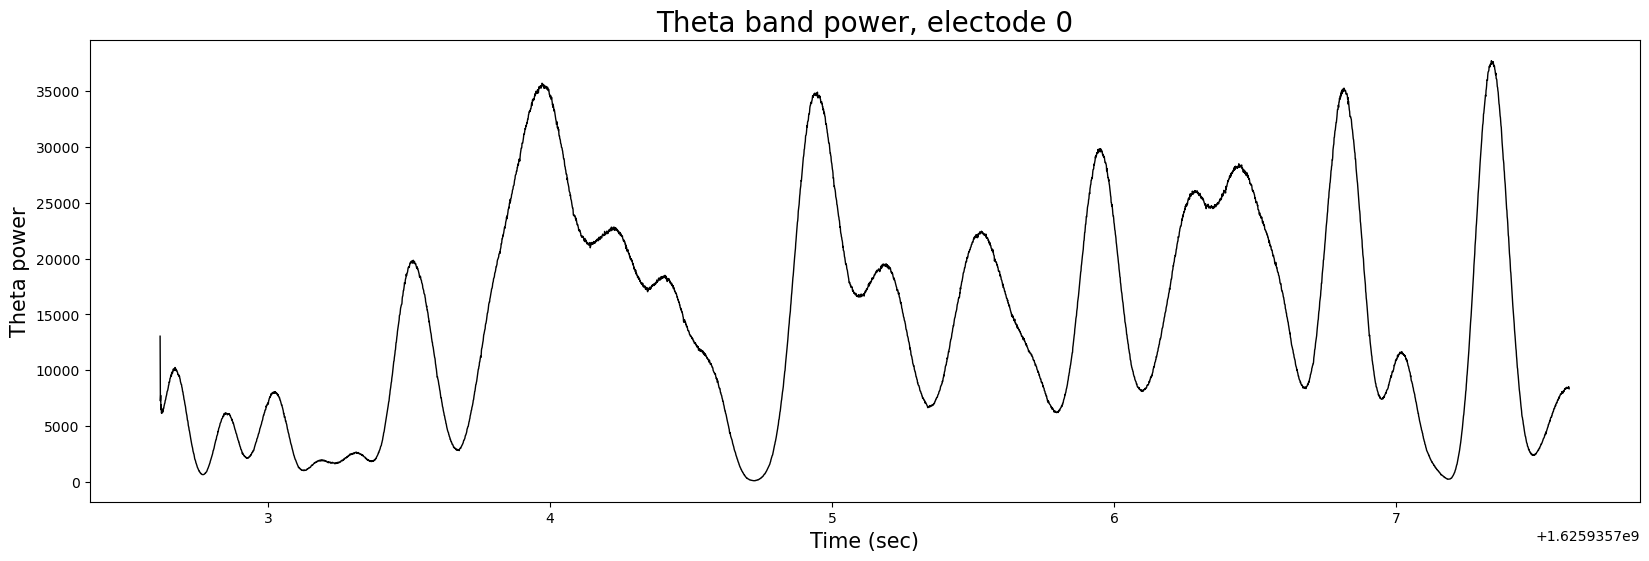

In [13]:
plot_start = 0
plot_end = 5000
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_xlabel("Time (sec)", fontsize=15)
ax.set_ylabel("Theta power", fontsize=15)
ax.plot(
    theta_power.index[plot_start:plot_end],
    theta_power[f"electrode {electrode_id}"].iloc[plot_start:plot_end],
    "k-",
    linewidth=1,
)
ax.tick_params(axis="y", labelcolor="k")
ax.set_title(
    f"Theta band power, electode {electrode_id}",
    fontsize=20,
);